In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [10]:
data = np.loadtxt("./data2/multiple_variable.txt", delimiter="\t")

In [11]:
# 特征和目标变量
X = data[:, :-1]  # 假设最后一列是目标变量
y = data[:, -1]

# 数据预处理
# 标准化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [12]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [13]:
# 创建数据加载器
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 定义多变量线性回归模型
class MultipleLinearRegression(nn.Module):
    def __init__(self, input_features):
        super(MultipleLinearRegression, self).__init__()
        self.linear = nn.Linear(input_features, 1)
        
    def forward(self, x):
        return self.linear(x)

# 初始化模型、损失函数和优化器
input_features = X.shape[1]
model = MultipleLinearRegression(input_features)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [14]:
# 训练模型
num_epochs = 200
losses = []

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 记录损失
    with torch.no_grad():
        train_outputs = model(X_train)
        epoch_loss = criterion(train_outputs, y_train)
        losses.append(epoch_loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss.item():.4f}')

Epoch [20/200], Loss: 0.0040
Epoch [40/200], Loss: 0.0001
Epoch [60/200], Loss: 0.0000
Epoch [80/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [120/200], Loss: 0.0000
Epoch [140/200], Loss: 0.0000
Epoch [160/200], Loss: 0.0000
Epoch [180/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000


In [15]:
# 模型评估
with torch.no_grad():
    # 训练集评估
    train_predictions = model(X_train).numpy()
    train_r2 = r2_score(y_train.numpy(), train_predictions)
    train_mse = mean_squared_error(y_train.numpy(), train_predictions)
    
    # 测试集评估
    test_predictions = model(X_test).numpy()
    test_r2 = r2_score(y_test.numpy(), test_predictions)
    test_mse = mean_squared_error(y_test.numpy(), test_predictions)
    
print(f'Training R² Score: {train_r2:.4f}, Training MSE: {train_mse:.4f}')
print(f'Testing R² Score: {test_r2:.4f}, Testing MSE: {test_mse:.4f}')

Training R² Score: 1.0000, Training MSE: 0.0000
Testing R² Score: 1.0000, Testing MSE: 0.0000


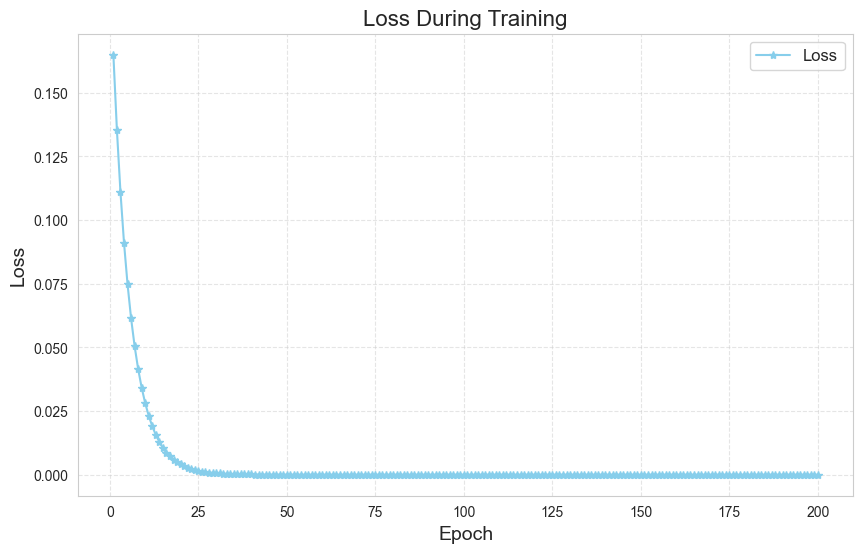

linear.weight: [0.02861651 0.05702899 0.08161838]
linear.bias: [0.69451183]


In [16]:
# 绘制损失曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='skyblue', marker='*', linestyle='-')
plt.title("Loss During Training", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 打印模型参数
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data.numpy().flatten()}')

In [17]:
# 可视化（假设我们有三个特征，选择前两个特征进行3D展示）
if X.shape[1] >= 2:
    # 创建网格以绘制回归平面
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 50), np.linspace(x2_min, x2_max, 50))
    X_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # 如果有更多特征，用均值填充
    if X.shape[1] > 2:
        mean_features = np.mean(X, axis=0)
        X_grid = np.hstack([X_grid, np.tile(mean_features[2:], (X_grid.shape[0], 1))])

    # 预测网格点的值
    y_grid = model.predict(X_grid)
    y_grid = y_grid.reshape(x1_grid.shape)

    # 创建3D散点图和回归平面
    trace1 = go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=y,
        mode='markers',
        marker=dict(
            size=4,
            color=y,
            colorscale='Viridis',
            opacity=0.8
        ),
        name='Data Points'
    )

    trace2 = go.Surface(
        x=x1_grid,
        y=x2_grid,
        z=y_grid,
        colorscale='Blues',
        opacity=0.7,
        name='Regression Plane'
    )

    layout = go.Layout(
        title='3D Visualization of Multiple Linear Regression',
        scene=dict(
            xaxis_title='Feature 1',
            yaxis_title='Feature 2',
            zaxis_title='Target Variable'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=800,
        width=1000
    )

    fig = go.Figure(data=[trace1, trace2], layout=layout)

    # 保存为HTML文件
    plotly.offline.plot(fig, filename='multiple_linear_regression.html')

    # 如果需要显示图表
    fig.show()
else:
    print("需要至少两个特征才能进行3D可视化")

AttributeError: 'MultipleLinearRegression' object has no attribute 'predict'